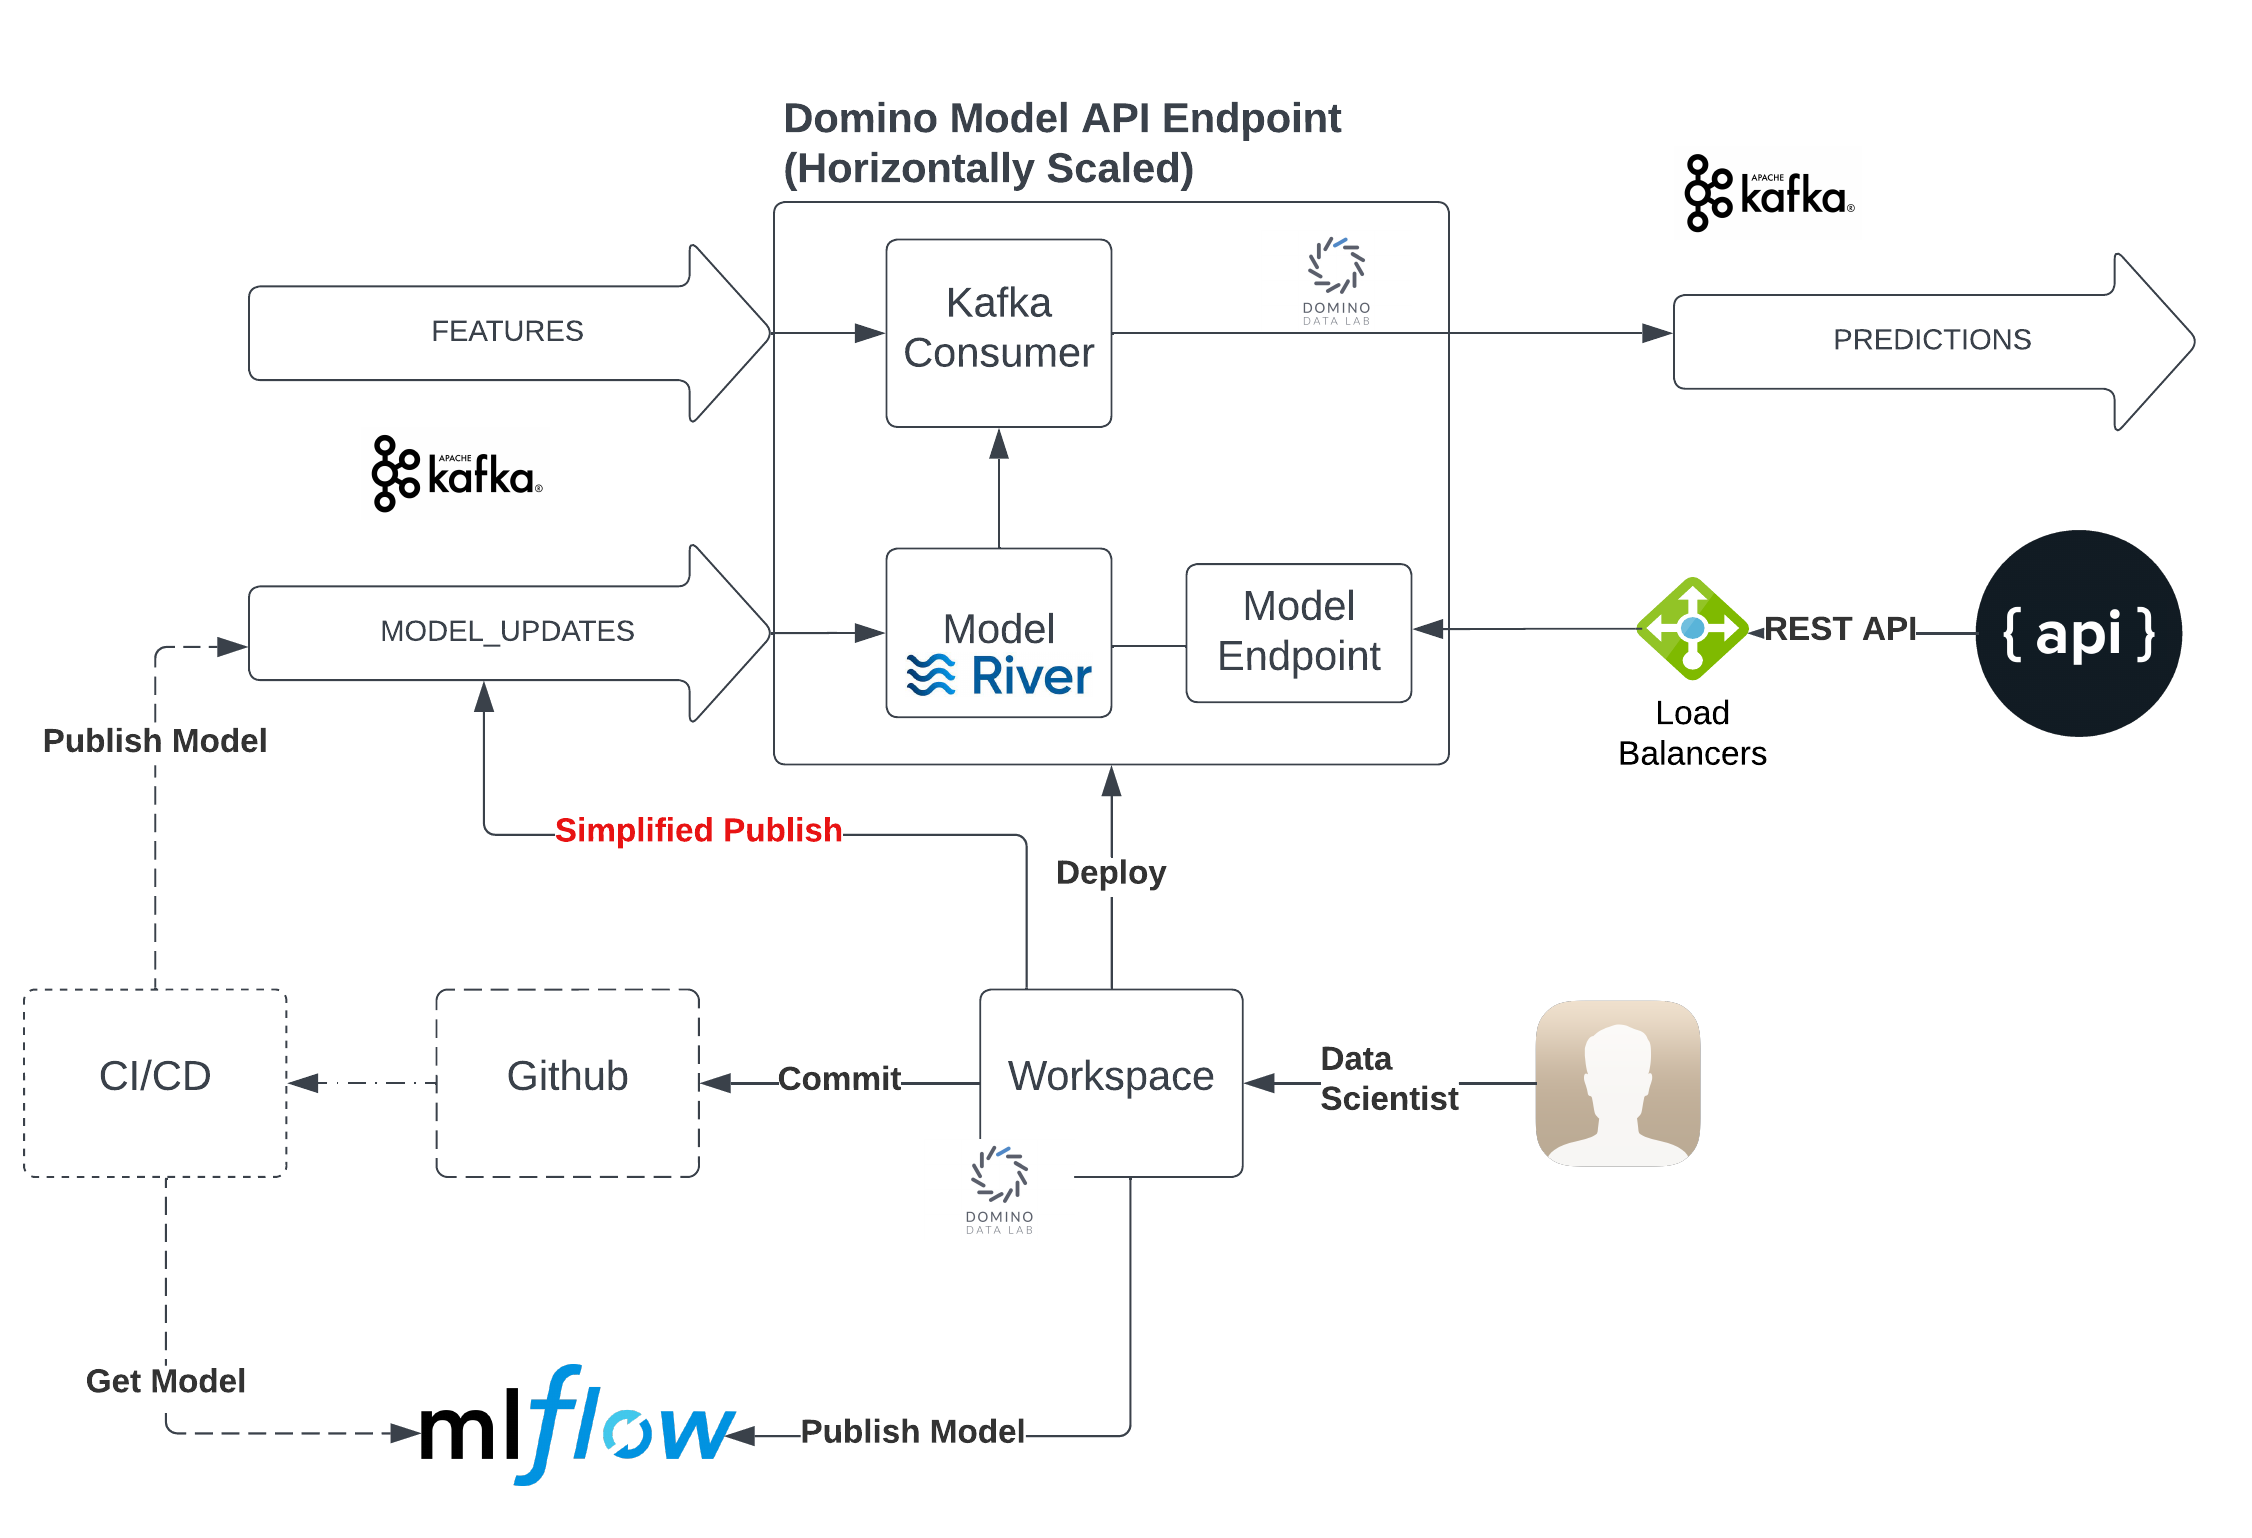

In [12]:
from IPython import display
display.Image('/mnt/code/assets/kafka_model.png')

In [31]:
import os
from river import datasets
from river import metrics
from river import tree
from river import ensemble
from river import evaluate
from river import compose
from river import naive_bayes
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from confluent_kafka import Producer,Consumer
import certifi
import time
import json
import pandas
import mlflow
import codecs
import pickle
import sys
from datetime import datetime

## Prepare to publish models to the Model Update Topic

All model updates are directly pushed to the topic `model_updates` as a serialized pickle file content which is base64 encoded.

This is not the ideal mecahnism to publish model updates. We would typically only publish the `model_name` and `model_version` because
Kafka topics are not designed to handle more than 8MB of payload. However to keep this demo simplified we are publishing our model updates directly to the topic

In [32]:
user= os.environ['KAFKA_USER_NAME']
password= os.environ['KAFKA_PASSWORD']
bsts= os.environ['KAFKA_BOOTSTRAP_SERVERS']
topic = 'model_updates'
conf = {'bootstrap.servers': bsts,
            'sasl.mechanism': 'PLAIN',
            'security.protocol': 'SASL_SSL',
            'ssl.ca.location': certifi.where(),
            'sasl.username': user,
            'sasl.password': password,            
            'message.max.bytes': 8000000,
            'linger.ms': 100,
            'client.id': 'model-icde-2023-2'}
producer = Producer(conf) 

`get_model_artifact(run_id)` - Download the model artifacts (pickle file in our case) based on the experiment run_id and save it a local file path `models/model.pkl`. Again note that is a simplified example

`publish_model_update_to_model_endpoint` - Publish the model pickle file contents as a base64 encoded to the topic `model_updates` along with the `model_version` which is obtained from the model registry

In [33]:

def get_model_artifact(run_id):
    local_path = client.download_artifacts(run_id, "models/model.pkl", '/tmp/')
    with open(local_path, 'rb') as f:
        m_a = pickle.load(f)
        return m_a

def publish_model_update_to_model_endpoint(run_id,model_version):
    m_a = get_model_artifact(run_id)

    pkd = pickle.dumps(m_a)
    pickled = codecs.encode(pkd, "base64").decode()
    v=model_version
    model_json={'m':pickled,'v':v}
    
    msg = json.dumps(model_json)
    print(f'Model size : {sys.getsizeof(msg)}')
    print(f'Publishing to topic {topic}')
    producer.produce(topic, value=msg, key=str(v))
    producer.flush()


### Initialize metrics for training

We initialize three metrics-
1. ROCAUC
2. F1
3. MicroRecall

This time we simply do multiple runs in sequence. In a typical scenario we would follow this process:
1. Register metrics per run
2. When executing a subsequent run, fetch the model artifact and metrics from the previous run
3. Refine the previous run's model with the incremental dataset and refine the previous runs metrics
4. Store the refined model artifact and the new metrics for the current run

For simplicity, we simply keep the previous model version and metrics and for each run incrementall refine them and save it to the run artifacts in the experiment manager.

In [34]:
auc = metrics.ROCAUC()
f1 = metrics.F1()
recall = metrics.MicroRecall()

###  Experiment Creation

Create a new experiment or use the previously created one by name

In [35]:
from mlflow import MlflowClient
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
client = MlflowClient()
EXPERIMENT_NAME = 'AdaptiveRandomForestExperiment-v3'
model_name = EXPERIMENT_NAME
exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
model_artifact = None
if not exp:
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
    model_artifact = ensemble.AdaptiveRandomForestClassifier(leaf_prediction="mc")
else:
    EXPERIMENT_ID = exp.experiment_id


###  Run Generation

The method `generate_run(exp_id,index,model_artifact)` creates a run for the experiment created in the previous step. The run name is based on the following implementation:
```
s = now.strftime("%d-%m-%H-%M-%S")
run_name = f'run{s}-idx-{index}'
```

The method takes three parameters:
1. `exp_id` - Experiment id in the MLflow
2. `index` - This is a running number. We start with 0 and run 5 more runs which gives us indexes 0-6
3. `model_artifact` - The model generated by the previous runs. Remember, this is online-learning where each version builds on its previous version


In [36]:
def generate_run(exp_id,index,model_artifact):
    global auc
    global f1
    global recall
    idx=0
    now = datetime.now()
    s = now.strftime("%d-%m-%H-%M-%S")
    run_name = f'run{s}-idx-{index}'
    
    with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as run:
        # Retrieve run id
        RUN_ID = run.info.run_id
        size=100 * (index+2)
        max_train_size=100
        max_size=200
        
        skip_size = size - max_size
        dataset = datasets.MaliciousURL()
        data = dataset.take(size)
        cnt = 0
        if skip_size == 0:
            print(f'First Time Building Model')
            for f, y in data:
                cnt = cnt + 1
                if (cnt<=max_train_size):
                    model_artifact = model_artifact.learn_one(f,y)
                else:
                    score = model_artifact.predict_one(f)
                    auc = auc.update(y,score)
                    f1 = f1.update(y, score)
                    recall = recall.update(y, score)
        else:
            cnt = 0
            for f, y in data:
                cnt = cnt + 1
                if(cnt==skip_size):
                    break
            print(f'Skipped{skip_size}')
            for f, y in data:
                cnt = cnt + 1
                if (cnt<=max_train_size):
                    model_artifact = model_artifact.learn_one(f,y)
                else:
                    score = model_artifact.predict_one(f)
                    auc = auc.update(y,score)
                    f1 = f1.update(y, score)
                    recall = recall.update(y, score)
                

            
        # Track parameters
        mlflow.log_param("leaf_prediction", "mc")
        mlflow.log_metric("ROCAUC", auc.get())
        mlflow.log_metric("f1", auc.get())
        mlflow.log_metric("recall", auc.get())
        
        with open('/tmp/model.pkl', 'wb') as handle:
            pickle.dump(model_artifact, handle, protocol=pickle.HIGHEST_PROTOCOL)
        mlflow.log_artifact('/tmp/model.pkl','models')
        return run.info

###  Get Latest Model Version

MLflow supports the concept of `RegisteredModels` by name. Each registered models can have incrementing versions. Ths method below returns the latest version for a given model.

In [37]:
def get_latest_model_version_from_model_registry(registered_model):
    versions = registered_model.latest_versions
    current_version = None
    if(len(versions)>1):
        current_version = versions[1]
    else:
        current_version = versions[0]
    return current_version


###  Generate the model version 1
Execute a run and register the model. Push the model version to the kafka topic `model_updates` to which the model endpoint is listening

In [38]:
index=0
#First time creating model
model_artifact = ensemble.AdaptiveRandomForestClassifier(leaf_prediction="mc")
run = generate_run(EXPERIMENT_ID,index,model_artifact)

registered_model = None
try:
    registered_model = client.get_registered_model(model_name)
except:
     client.create_registered_model(model_name)
registered_model = client.get_registered_model(model_name)
model_uri = "runs:/{}/model".format(run.run_id)
result = client.create_model_version(
    name=model_name,
    source=model_uri,
    run_id=run.run_id,
) 
registered_model = client.get_registered_model(model_name)
current_model_version = get_latest_model_version_from_model_registry(registered_model)
publish_model_update_to_model_endpoint(run.run_id,current_model_version.version)

First Time Building Model


2023/04/06 01:29:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaptiveRandomForestExperiment-v3, version 11
/tmp/ipykernel_1560/141354391.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  local_path = client.download_artifacts(run_id, "models/model.pkl", '/tmp/')


Model size : 2348563
Publishing to topic model_updates


###  Generate the model version 2-6
Execute a runs 2-6 and register each new model version
Push the model versions to the kafka topic `model_updates` to which the model endpoint is listening

In [30]:
for index in range(1,5):
    print(f'Currently on iteration {index}')
    current_model_version = get_latest_model_version_from_model_registry(registered_model)
    model_artifact = get_model_artifact(current_model_version.run_id)
    run = generate_run(EXPERIMENT_ID,index,model_artifact)
    registered_model = None
    try:
        registered_model = client.get_registered_model(model_name)
    except:
         client.create_registered_model(model_name)
    model_uri = "runs:/{}/model".format(run.run_id)
    result = client.create_model_version(
        name=model_name,
        source=model_uri,
        run_id=run.run_id,
    ) 
    registered_model = client.get_registered_model(model_name)
    current_model_version = get_latest_model_version_from_model_registry(registered_model)
    publish_model_update_to_model_endpoint(run.run_id,current_model_version.version)


Currently on iteration 1


/tmp/ipykernel_1560/141354391.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  local_path = client.download_artifacts(run_id, "models/model.pkl", '/tmp/')


Skipped100


2023/04/06 01:27:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaptiveRandomForestExperiment-v3, version 7


Model size : 2456934
Publishing to topic model_updates
Currently on iteration 2
Skipped200


2023/04/06 01:27:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaptiveRandomForestExperiment-v3, version 8


Model size : 2456934
Publishing to topic model_updates
Currently on iteration 3
Skipped300


2023/04/06 01:27:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaptiveRandomForestExperiment-v3, version 9


Model size : 2456934
Publishing to topic model_updates
Currently on iteration 4
Skipped400


2023/04/06 01:27:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: AdaptiveRandomForestExperiment-v3, version 10


Model size : 2456935
Publishing to topic model_updates


## Produce Features to the Features Kafka Topic

Now use the `MaliciousURLModelProducer.ipynb` to publish features to the Kafka topic `features`. Monitor the topic `predictions` to determine if the model endpoint is processing the features and producing predictions using the latest model version

### Test the model init and predict function

```
import os
import model
model.init()
#model_test.init_get_latest_model()
x = {"2": 1.0, "4": 0.0788382, "5": 0.131034, "6": 0.117647, "10": 1.0, "11": 0.142857, "16": 0.4, "17": 0.830283, "18": 0.83965, "19": 0.583194, "20": 1.0, "21": 0.285713, "22": 0.00595238, "23": 0.00595238, "36": 1.0, "37": 1.0, "44": 1.0, "45": 1.0, "54": 1.0, "56": 1.0, "62": 1.0, "64": 1.0, "66": 1.0, "68": 1.0, "70": 1.0, "72": 1.0, "74": 1.0, "75": 0.25, "76": 1.0, "77": 0.166667, "79": 0.0769231, "81": 0.05, "82": 1.0, "84": 1.0, "86": 1.0, "88": 1.0, "90": 1.0, "92": 1.0, "94": 1.0, "96": 1.0, "102": 1.0, "104": 1.0, "106": 1.0, "108": 1.0, "110": 1.0, "112": 1.0, "131": 1.0, "133": 1.0, "139": 1.0, "141": 1.0, "143": 1.0, "145": 1.0, "147": 1.0, "149": 1.0, "253": 1.0, "260": 1.0, "277": 1.0, "304": 1.0, "305": 1.0, "425": 1.0, "521": 1.0, "673": 1.0, "674": 1.0, "675": 1.0, "676": 1.0, "731": 1.0, "732": 1.0, "733": 1.0, "1365": 1.0, "1488": 1.0, "2098": 1.0, "6027": 1.0, "6028": 1.0, "6029": 1.0, "6030": 1.0, "6031": 1.0, "9989": 1.0, "18073": 1.0, "18074": 1.0, "18077": 1.0, "18078": 1.0, "18079": 1.0, "18080": 1.0, "155153": 1.0, "155154": 1.0, "155155": 1.0, "155156": 1.0, "155157": 1.0, "155158": 1.0, "155159": 1.0, "155160": 1.0, "155161": 1.0, "155163": 1.0, "155164": 1.0, "155165": 1.0, "155166": 1.0, "155167": 1.0, "155168": 1.0, "155169": 1.0, "155170": 1.0, "155171": 1.0, "155172": 1.0, "155173": 1.0, "155174": 1.0, "155175": 1.0, "155176": 1.0, "155177": 1.0, "155178": 1.0, "155179": 1.0, "155180": 1.0, "155181": 1.0, "155182": 1.0, "155183": 1.0, "155184": 1.0, "155185": 1.0, "155186": 1.0, "155187": 1.0, "155188": 1.0, "155189": 1.0, "155190": 1.0, "155191": 1.0, "155192": 1.0, "155193": 1.0, "155194": 1.0, "155195": 1.0, "155196": 1.0, "155197": 1.0, "155198": 1.0, "155199": 1.0, "155200": 1.0, "155201": 1.0, "155202": 1.0, "155203": 1.0, "155204": 1.0, "155205": 1.0, "155206": 1.0, "155207": 1.0, "155208": 1.0, "155209": 1.0, "155210": 1.0, "155211": 1.0, "155212": 1.0, "155213": 1.0, "500481": 1.0}
model.predict(x)
```